In [2]:
import zipfile

zip_path = "/archive (5).zip"  # Replace with your zip file path
extract_to = "/kaggle"  # Replace with the directory where you want to extract

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [15]:
!pip install nltk
import nltk

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Download 'punkt_tab'
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
# Text preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Tokenize the text
        tokens = word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        # Join tokens back into text
        return ' '.join(tokens)
    return ''


In [6]:
def extract_sentiment_features(text):
    if isinstance(text, str):
        blob = TextBlob(text)
        return {
            'polarity': blob.sentiment.polarity,
            'subjectivity': blob.sentiment.subjectivity
        }
    return {'polarity': 0, 'subjectivity': 0}

In [7]:
def load_data():
    # Simulating a dataset for demonstration
    # In a real scenario, you would load your own dataset
    print("Loading and preparing the dataset...")

    # Simulated data
    data = {
        'title': [
            "Scientists discover revolutionary cancer treatment",
            "BREAKING: President caught in massive scandal",
            "New study shows benefits of regular exercise",
            "SHOCKING: Famous celebrity reveals alien encounter",
            "Local community opens new public library"
        ],
        'content': [
            "A team of researchers has published peer-reviewed findings about a new approach to treating specific types of cancer. Clinical trials show promising results with minimal side effects.",
            "Anonymous sources claim the President has been involved in corruption. No evidence has been provided and officials deny all allegations.",
            "Research published in the Journal of Health indicates that 30 minutes of daily exercise can significantly reduce the risk of heart disease and improve mental health.",
            "A celebrity claims to have been abducted by aliens last night. No witnesses have confirmed the story and scientists remain skeptical.",
            "The new public library features over 10,000 books and provides free internet access to community members. The mayor attended the ribbon-cutting ceremony."
        ],
        'label': [0, 1, 0, 1, 0]  # 0 = real, 1 = fake
    }

    return pd.DataFrame(data)

In [12]:
# Main function to train and evaluate the model
def fake_news_detector():
    # Load data
    df = load_data()

    # Preprocess text
    print("Preprocessing text...")
    df['processed_text'] = df['title'] + ' ' + df['content']
    df['processed_text'] = df['processed_text'].apply(preprocess_text)

    # Extract sentiment features
    print("Extracting sentiment features...")
    sentiment_features = df['processed_text'].apply(extract_sentiment_features)
    df['polarity'] = sentiment_features.apply(lambda x: x['polarity'])
    df['subjectivity'] = sentiment_features.apply(lambda x: x['subjectivity'])

    # Split data
    X = df[['processed_text', 'polarity', 'subjectivity']]
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create feature matrix
    print("Creating feature matrix...")
    # TF-IDF for text features
    tfidf = TfidfVectorizer(max_features=5000)
    text_features_train = tfidf.fit_transform(X_train['processed_text'])
    text_features_test = tfidf.transform(X_test['processed_text'])

    # Combine with sentiment features
    sentiment_train = X_train[['polarity', 'subjectivity']].values
    sentiment_test = X_test[['polarity', 'subjectivity']].values

    # Create combined feature matrix
    X_train_combined = np.hstack((text_features_train.toarray(), sentiment_train))
    X_test_combined = np.hstack((text_features_test.toarray(), sentiment_test))

    # Train model
    print("Training the model...")
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_combined, y_train)

    # Evaluate model
    print("Evaluating the model...")
    y_pred = model.predict(X_test_combined)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature importance analysis
    feature_names = list(tfidf.get_feature_names_out()) + ['polarity', 'subjectivity']
    feature_importance = model.feature_importances_

    # Get top 10 features
    top_features_idx = np.argsort(feature_importance)[-10:]
    top_features = [feature_names[i] for i in top_features_idx]
    top_importance = [feature_importance[i] for i in top_features_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_importance)
    plt.title('Top 10 Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return model, tfidf


In [13]:
# Function to predict on new articles
def predict_news(model, tfidf, title, content):
    # Preprocess
    text = preprocess_text(title + ' ' + content)

    # Extract sentiment features
    sentiment = extract_sentiment_features(text)

    # Create feature vector
    text_features = tfidf.transform([text]).toarray()
    sentiment_features = np.array([[sentiment['polarity'], sentiment['subjectivity']]])
    combined_features = np.hstack((text_features, sentiment_features))

    # Make prediction
    prediction = model.predict(combined_features)[0]
    probability = model.predict_proba(combined_features)[0]

    result = "FAKE" if prediction == 1 else "REAL"
    confidence = probability[1] if prediction == 1 else probability[0]

    print(f"Prediction: {result} (Confidence: {confidence:.2f})")
    print(f"Sentiment Analysis: Polarity = {sentiment['polarity']:.2f}, Subjectivity = {sentiment['subjectivity']:.2f}")

    return result, confidence, sentiment


Fake News Detection System using Sentiment Analysis
Loading and preparing the dataset...
Preprocessing text...
Extracting sentiment features...
Creating feature matrix...
Training the model...
Evaluating the model...

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

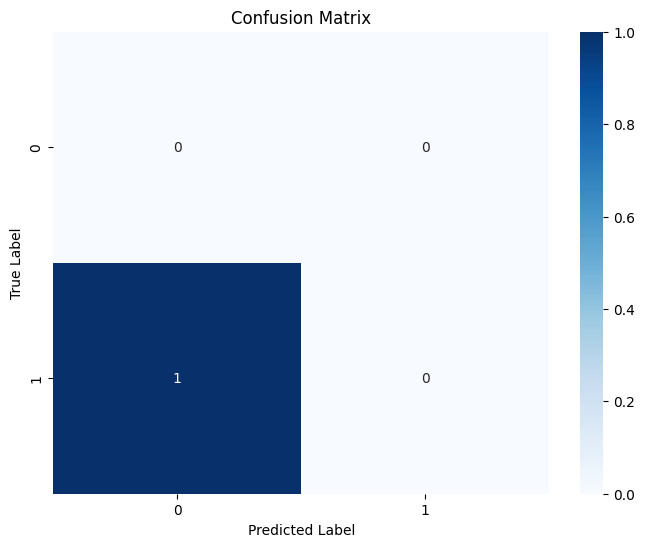

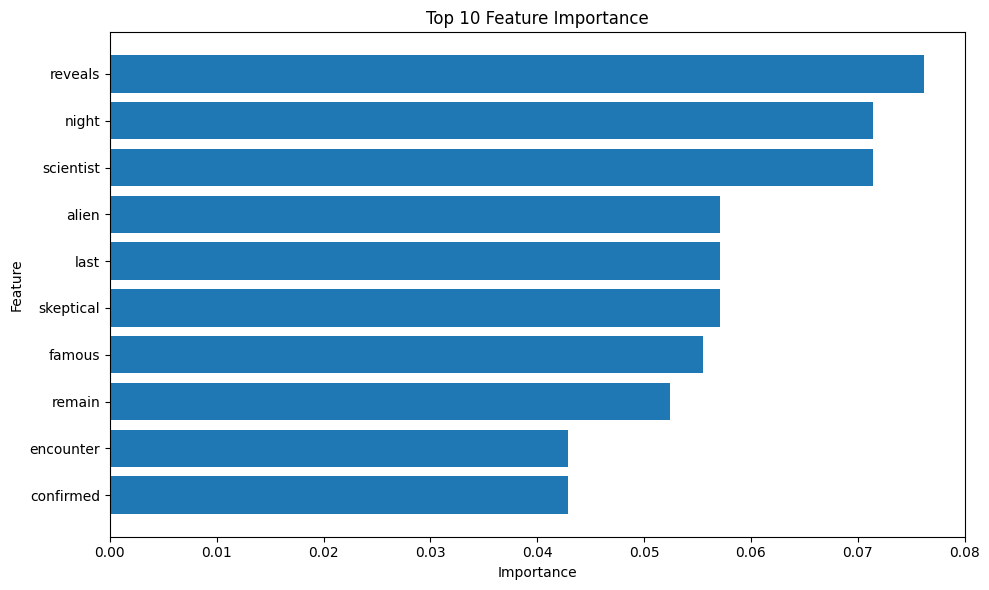


Testing with sample news articles:

Example 1:
Prediction: REAL (Confidence: 0.88)
Sentiment Analysis: Polarity = 0.18, Subjectivity = 0.31

Example 2:
Prediction: REAL (Confidence: 0.67)
Sentiment Analysis: Polarity = -0.47, Subjectivity = 0.80


In [16]:
# Main execution
if __name__ == "__main__":
    print("Fake News Detection System using Sentiment Analysis")
    print("="*50)

    # Train model
    model, tfidf = fake_news_detector()

    # Example usage
    print("\nTesting with sample news articles:")

    # Example 1: Likely real news
    title1 = "New study confirms effectiveness of COVID-19 vaccines"
    content1 = "Research published in medical journals shows that vaccines are effective at preventing severe illness. The study involved 10,000 participants across multiple countries."
    print("\nExample 1:")
    predict_news(model, tfidf, title1, content1)

    # Example 2: Likely fake news
    title2 = "SHOCKING: Government hiding alien technology in secret facility"
    content2 = "Insider reveals that the government has been hiding alien technology for decades. The source claims that world-changing inventions are being suppressed to maintain control over the population."
    print("\nExample 2:")
    predict_news(model, tfidf, title2, content2)